# Bandit Problem

In [59]:
# imports
from bandits import Bandit
# import random
# Include your imports here, if any are used. 
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [60]:
def get_bandits(low = -2, high = 2, count = 10):
    return np.array([Bandit(np.random.uniform(low = low, high = high)) for _ in range(count)])

In [92]:
# The ignore equality after parameter is just for runtime optimization, it speeds up the program by nearly 4x

def run_algorithm(algorithm, bandits: np.ndarray, time_steps: int, estimates: np.ndarray  = None, ignore_equality_after: int = None, **kwargs):
    # Initilization
    if type(estimates) == type(None):
        estimates = np.zeros_like(bandits, dtype="float64")
    elif estimates.shape != bandits.shape:
        raise ValueError("shapes of estimates and bandits does not match")
    
    trials = np.zeros_like(bandits, dtype="float64")

    if ignore_equality_after == None:
        ignore_equality_after = int(time_steps / 10)

    rewards = np.zeros(time_steps)

    # Just checking performance
    ideal_arm = np.argmax([bandit.mean() for bandit in bandits])
    ideal_choice = np.zeros(time_steps)

    # Run each action
    for i in range(time_steps):
        # Decide the action and get the reward
        a_i = algorithm(estimates = estimates, trials = trials, i = i, ignore_equality_after = ignore_equality_after, **kwargs)
        reward = bandits[a_i].pullLever()

        # Check if the action was ideal
        if a_i == ideal_arm:
            ideal_choice[i] = 1

        # Update variables
        rewards[i] = reward
        trials[a_i] += 1
        estimates[a_i] += (reward - estimates[a_i]) / trials[a_i]

    return rewards, ideal_choice

In [62]:
def get_averaged_results(algo_runner, runs_count=2000, time_steps=1000, seed=0, show_progress=True, **kwargs):
    # Set seed for reproducibility
    np.random.seed(seed)

    # Properties of the runs
    rewards_sum = np.zeros(time_steps)
    ideal_choices = np.zeros(time_steps)

    # Execute each run
    looper = tqdm(range(runs_count)) if show_progress else range(runs_count)
    for i in looper:
        rewards, ideal_choice = algo_runner(bandits = get_bandits(), time_steps = time_steps, **kwargs)

        rewards_sum += rewards
        ideal_choices += ideal_choice

    # Calculate averaged value
    cum_avg_rewards = rewards_sum.cumsum() / (np.arange(time_steps) + 1) / runs_count
    ideal_choice_fraction = ideal_choices / runs_count

    return cum_avg_rewards, ideal_choice_fraction

## Greedy algorithm Implementation

In [63]:
def run_greedy(bandits, time_steps):

    def greedy_algorithm(estimates, i, ignore_equality_after, **kwargs):
        if ignore_equality_after >= i:
            return np.random.choice(np.nonzero(estimates == estimates.max())[0])
        else:
            return estimates.argmax()

    return run_algorithm(greedy_algorithm, bandits, time_steps)

Plot the cumulative average of rewards as the number of iterations increases.

In [64]:
cum_avg_rewards, ideal_choice_fraction = get_averaged_results(run_greedy)

100%|██████████| 2000/2000 [00:08<00:00, 238.31it/s]


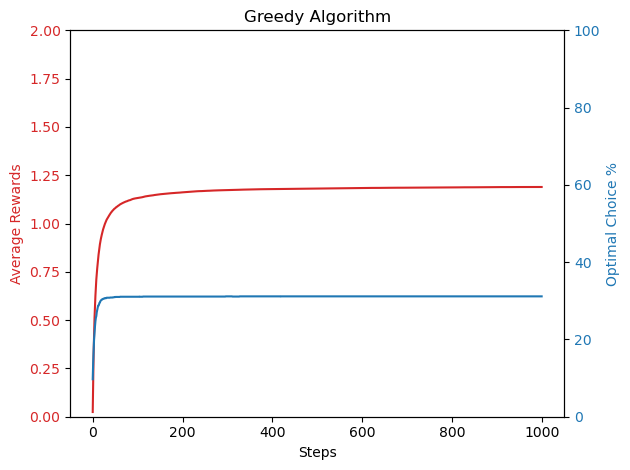

In [65]:
fig, ax1 = plt.subplots()
clr1, clr2 = "tab:red", "tab:blue"


ax1.set_xlabel("Steps")
ax1.set_ylabel("Average Rewards", color=clr1)
ax1.tick_params(axis = 'y', labelcolor=clr1)
ax1.plot(cum_avg_rewards, color=clr1)
ax1.set_ybound(0, 2)

ax2 = ax1.twinx()

ax2.set_ylabel("Optimal Choice %", color=clr2)
ax2.tick_params(axis = 'y', labelcolor=clr2)
ax2.plot(ideal_choice_fraction * 100, color=clr2)
ax2.set_ybound(0, 100)


ax1.set_title("Greedy Algorithm")
fig.tight_layout()
plt.show()

## $\epsilon$-greedy Algorithm

In [ ]:
def run_epsilon_greedy(bandits, time_steps, epsilon, **kwargs):

    def epsilon_greedy_algorithm(estimates, ignore_equality_after, i, **kwargs):
        if np.random.random() >= epsilon:
            if ignore_equality_after >= i:
                return np.random.choice(np.nonzero(estimates == estimates.max())[0])
            else:
                return estimates.argmax()
        else:
            return np.random.randint(estimates.size)

    return run_algorithm(epsilon_greedy_algorithm, bandits, time_steps, **kwargs)

Plot the cumulative average of rewards as the number of iterations increases but for various values of $\epsilon$.

In [ ]:
epsilons = [0.5, 0.1, 0.01, 0]


results = [get_averaged_results(run_epsilon_greedy, epsilon = epsilon) for epsilon in epsilons]

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:14<00:00, 134.68it/s]


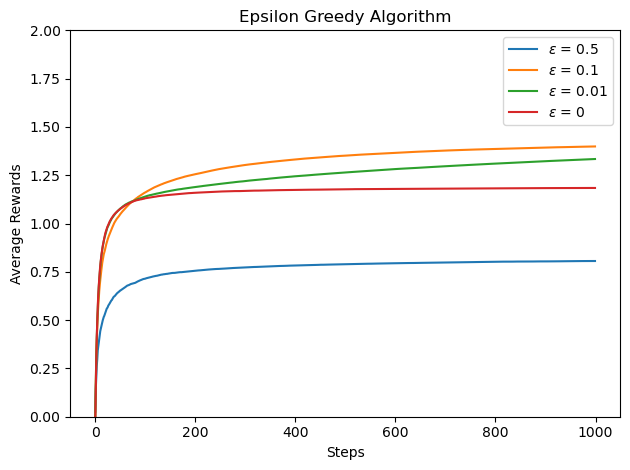

In [ ]:
fig, ax = plt.subplots()


ax.set_xlabel("Steps")
ax.set_ylabel("Average Rewards")
for result in results:
    ax.plot(result[0])

ax.set_ybound(0, 2)

ax.legend([f"$\\epsilon$ = {epsilon}" for epsilon in epsilons])

ax.set_title("Epsilon Greedy Algorithm")
fig.tight_layout()
plt.show()

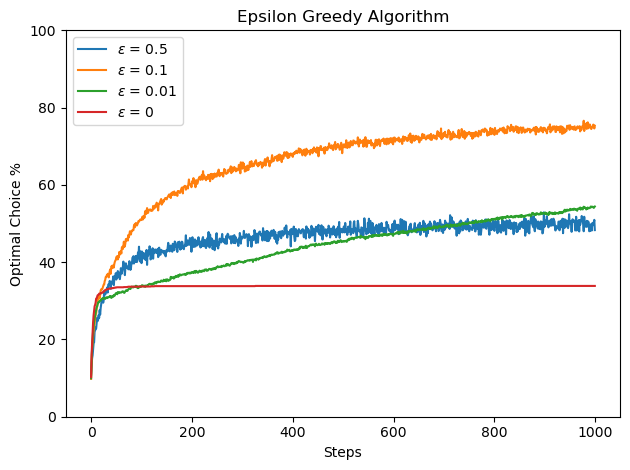

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel("Steps")
ax.set_ylabel("Optimal Choice %")
for result in results:
    ax.plot(result[1] * 100)

ax.set_ybound(0, 100)

ax.legend([f"$\\epsilon$ = {epsilon}" for epsilon in epsilons])

ax.set_title("Epsilon Greedy Algorithm")
fig.tight_layout()
plt.show()

## Finding the optimal $\epsilon$

Run the $\epsilon$-greedy algorithm for 1000 iterations and find the optimal $\epsilon$ value by plotting the cumulative average of rewards for various values of $\epsilon$

In [ ]:
# Uneven distribution of epsilons to account for sensitivity near maxima
epsilons = np.concat((
    np.linspace(0, 0.2, 101),
    np.linspace(0.2, 0.5, 16),
    np.linspace(0.5, 1.0, 6)
))

avg_rewards = np.zeros_like(epsilons)
for i in tqdm(range(epsilons.size)):
    avg_rewards[i] = get_averaged_results(run_epsilon_greedy, epsilon=epsilons[i], runs_count=2000, show_progress = False)[0][-1]

  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [20:15<00:00,  9.88s/it]


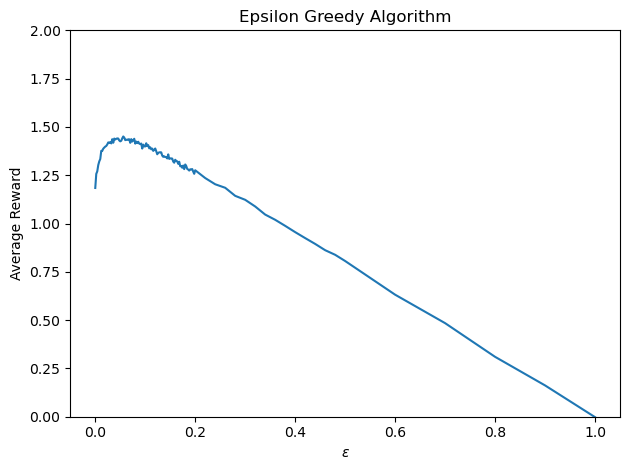

Optimal value of epsilon is nearly 0.056


In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel("$\\epsilon$")
ax.set_ylabel("Average Reward")

ax.plot(epsilons, avg_rewards)

ax.set_ybound(0, 2)

ax.set_title("Epsilon Greedy Algorithm")
fig.tight_layout()
plt.show()

print(f"Optimal value of epsilon is nearly {epsilons[avg_rewards.argmax()]}")

## Optimistic Initial Values

In [ ]:
def run_optimistic_greedy(bandits, time_steps, epsilon, q1, **kwargs):

    def optimistic_greedy_alogirithm(estimates, ignore_equality_after, i, **kwargs):
        if np.random.random() >= epsilon:
            if ignore_equality_after >= i:
                return np.random.choice(np.nonzero(estimates == estimates.max())[0])
            else:
                return estimates.argmax()
        else:
            return np.random.randint(estimates.size)

    return run_algorithm(optimistic_greedy_alogirithm, bandits, time_steps, estimates = q1 * np.ones_like(bandits, dtype="float64"), **kwargs)

Plot the cumulative average of rewards as the number of iterations increases for an optimistic greedy of $Q_1 = 10$ and a non-optimistic $\epsilon = 0.1$

In [96]:
cum_avg_rewards, ideal_choice_fraction = get_averaged_results(run_optimistic_greedy, epsilon = 0.1, q1 = 10)

100%|██████████| 2000/2000 [00:10<00:00, 195.30it/s]


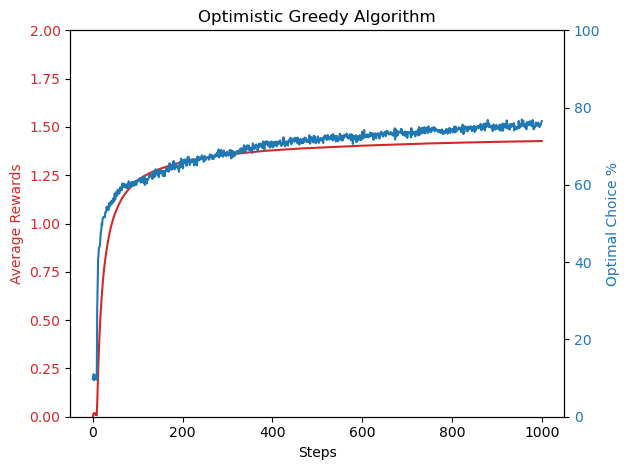

In [97]:
fig, ax1 = plt.subplots()
clr1, clr2 = "tab:red", "tab:blue"


ax1.set_xlabel("Steps")
ax1.set_ylabel("Average Rewards", color=clr1)
ax1.tick_params(axis = 'y', labelcolor=clr1)
ax1.plot(cum_avg_rewards, color=clr1)
ax1.set_ybound(0, 2)

ax2 = ax1.twinx()

ax2.set_ylabel("Optimal Choice %", color=clr2)
ax2.tick_params(axis = 'y', labelcolor=clr2)
ax2.plot(ideal_choice_fraction * 100, color=clr2)
ax2.set_ybound(0, 100)


ax1.set_title("Optimistic Greedy Algorithm")
fig.tight_layout()
plt.show()

## Optional - Upper Confidence Bound (UCB)

In [93]:
def run_ucb(bandits, time_steps, c, **kwargs):

    def ucb_algorithm(estimates, ignore_equality_after, i, trials, **kwargs):
        
        if np.any(trials == 0):
            return np.random.choice(np.nonzero(trials == 0)[0])

        preferences = estimates + c * np.sqrt(np.log(i) / trials)

        if ignore_equality_after >= i:
            return np.random.choice(np.nonzero(preferences == preferences.max())[0])
        else:
            return preferences.argmax()

    return run_algorithm(ucb_algorithm, bandits, time_steps, **kwargs)

In [102]:
cum_avg_rewards, ideal_choice_fraction = get_averaged_results(run_ucb, c = 1)

100%|██████████| 2000/2000 [00:28<00:00, 70.51it/s]


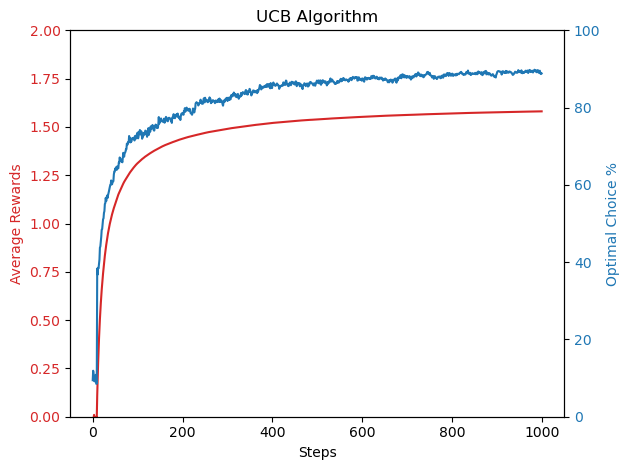

In [103]:
fig, ax1 = plt.subplots()
clr1, clr2 = "tab:red", "tab:blue"


ax1.set_xlabel("Steps")
ax1.set_ylabel("Average Rewards", color=clr1)
ax1.tick_params(axis = 'y', labelcolor=clr1)
ax1.plot(cum_avg_rewards, color=clr1)
ax1.set_ybound(0, 2)

ax2 = ax1.twinx()

ax2.set_ylabel("Optimal Choice %", color=clr2)
ax2.tick_params(axis = 'y', labelcolor=clr2)
ax2.plot(ideal_choice_fraction * 100, color=clr2)
ax2.set_ybound(0, 100)


ax1.set_title("UCB Algorithm")
fig.tight_layout()
plt.show()